## Garbage classifier

So many kinds of garbage bins in Belgium, even depending on in which city you live... It's hard to remember all the do's and don'ts and sort waste correctly. This is my attempt at creating a classifier that is fed a picture and detect what type of garbage is in it. This uses Roboflow and YOLOv8. It doesn't work spectacularly well, but honestly, this is based on less than 100 images and this was really about the journey, not the destination. If I ever have time to spare I will start taking pictures of whatever I toss in the bin and feed it to the algorithm to make it smarter ;-).

First we start with the classification for single images.

In [1]:
def classify_single(input_image):
    import cv2
    from roboflow import Roboflow
    rf = Roboflow(api_key='my_api_key')
    project = rf.workspace().project("garbage-classifier-ut04g")
    model = project.version(1).model


    img = cv2.imread(input_image)
    
    response=model.predict(img, confidence=40, overlap=30).json()
    detections = response['predictions']


    for bounding_box in detections:
        x0 = bounding_box['x'] - bounding_box['width'] / 2
        x1 = bounding_box['x'] + bounding_box['width'] / 2
        y0 = bounding_box['y'] - bounding_box['height'] / 2
        y1 = bounding_box['y'] + bounding_box['height'] / 2
        class_name = bounding_box['class']
        confidence = bounding_box['confidence']
        # position coordinates: start = (x0, y0), end = (x1, y1)
        # color = RGB-value for bounding box color, (0,0,0) is "black"
        # thickness = stroke width/thickness of bounding box
        start_point = (int(x0), int(y0))
        end_point = (int(x1), int(y1))
        # draw/place bounding boxes on image
        cv2.rectangle(img, start_point, end_point, color=(256, 0, 0), thickness=2)

        (text_width, text_height), _ = cv2.getTextSize(
            f"{class_name} | {confidence}",
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, thickness=2)

        cv2.rectangle(img, (int(x0), int(y0)), (int(x0) + text_width, int(y0) + text_height), color=(256, 0, 0),
                      thickness=-1)

        text_location = (int(x0), int(y0)+ text_height)

        cv2.putText(img, f"{class_name} | {confidence}",
                    text_location, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7,
                    color=(255, 255, 255), thickness=2)
    
    return img

In [3]:
test_case=classify_single('6396f35dfc97666fdf78c2a7_NOMOQ-productfotografie-20221028-Rotterdam-063.jpg')

loading Roboflow workspace...
loading Roboflow project...


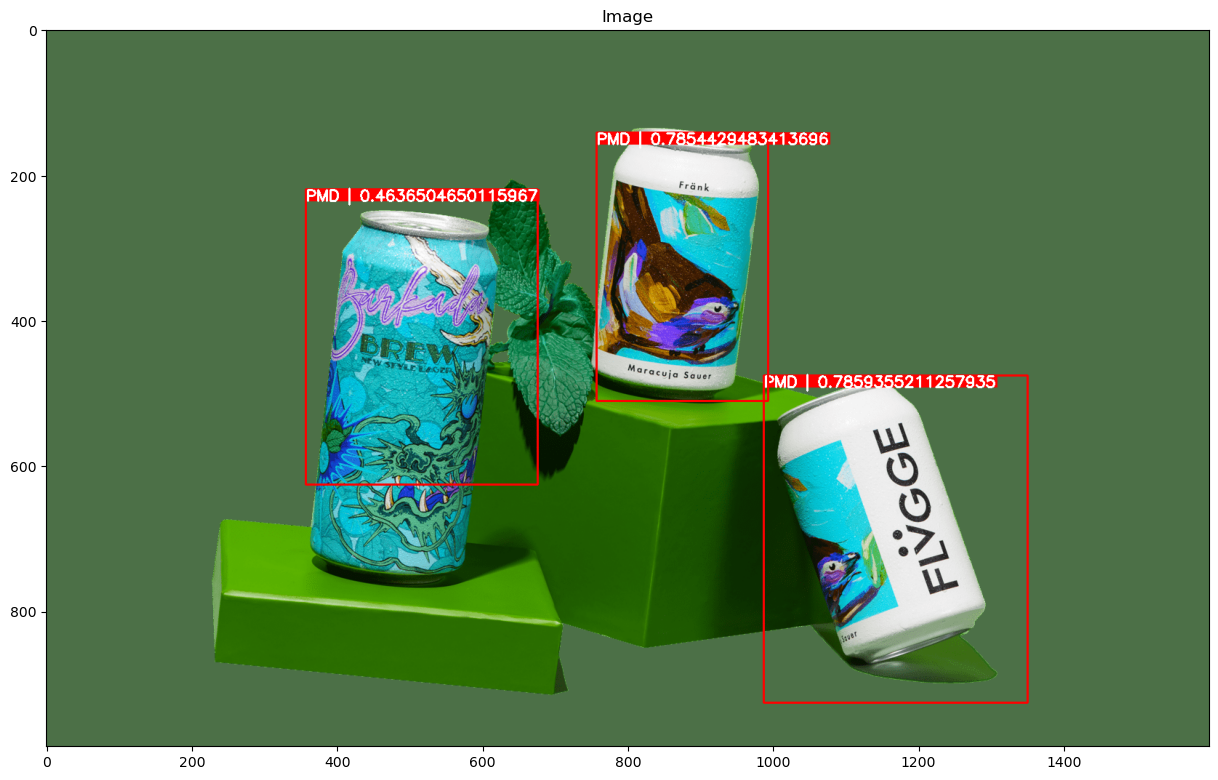

In [4]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15, 10]
plt.imshow(test_case)
plt.title('Image')
plt.show()

That works, so now we modify this function slightly so it can be put into a simple application (see next section).

In [5]:
def classify(input_image):
    import cv2
    from roboflow import Roboflow
    rf = Roboflow(api_key="9vWfKS15TTok0k2jurjf")
    project = rf.workspace().project("garbage-classifier-ut04g")
    model = project.version(1).model

    img=input_image
    
    response=model.predict(img, confidence=40, overlap=30).json()
    detections = response['predictions']


    for bounding_box in detections:
        x0 = bounding_box['x'] - bounding_box['width'] / 2
        x1 = bounding_box['x'] + bounding_box['width'] / 2
        y0 = bounding_box['y'] - bounding_box['height'] / 2
        y1 = bounding_box['y'] + bounding_box['height'] / 2
        class_name = bounding_box['class']
        confidence = bounding_box['confidence']
        # position coordinates: start = (x0, y0), end = (x1, y1)
        # color = RGB-value for bounding box color, (0,0,0) is "black"
        # thickness = stroke width/thickness of bounding box
        start_point = (int(x0), int(y0))
        end_point = (int(x1), int(y1))
        # draw/place bounding boxes on image
        cv2.rectangle(img, start_point, end_point, color=(256, 0, 0), thickness=2)

        (text_width, text_height), _ = cv2.getTextSize(
            f"{class_name} | {confidence}",
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, thickness=2)

        cv2.rectangle(img, (int(x0), int(y0)), (int(x0) + text_width, int(y0) + text_height), color=(256, 0, 0),
                      thickness=-1)

        text_location = (int(x0), int(y0)+ text_height)

        cv2.putText(img, f"{class_name} | {confidence}",
                    text_location, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7,
                    color=(255, 255, 255), thickness=2)    
    return img

# Making a user interface

It's important to be able to show your work to a non-technical audience that may feel uncomfortable looking at code, so here's a quick way to make a simple user interface:

In [6]:
import gradio as gr
file = gr.inputs.Image(shape=(640,480), source="upload")
webapp = gr.interface.Interface(fn=classify, inputs=file, outputs="image")

Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
`optional` parameter is deprecated, and it has no effect


In [7]:
webapp.launch(debug = 'True')
#webapp.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


loading Roboflow workspace...
loading Roboflow project...
Keyboard interruption in main thread... closing server.


I'm building in an additional functionality so that users could send me images that had no detection or the wrong detection. Under the hood this is done simply with an email to me. Just toying around :-).

In [10]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.image import MIMEImage
import cv2
import numpy as np

def send_email(message, image):
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    subject = 'New image for Garbage Classifier training!'
    to_email = 'my_email_address@email.ema'
    from_email = 'my_email_address@email.ema'
    password = 'my_password'
    
    # Convert the NumPy array to a JPEG file
    _, encoded_image = cv2.imencode('.jpg', image)
    image_data = encoded_image.tobytes()

    # Create the email message and attach the image
    msg = MIMEMultipart()
    msg['Subject'] = subject
    msg['From'] = from_email
    msg['To'] = to_email

    text = MIMEText(message)
    msg.attach(text)

    img = MIMEImage(image_data)
    img.add_header('Content-Disposition', 'attachment', filename="image.jpg")
    msg.attach(img)

    # Send the email using SMTP
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(from_email, password)
    server.sendmail(from_email, to_email, msg.as_string())
    server.quit()
    
    return "Picture added to database. Thank you for your input!"

In [9]:
import gradio as gr

with gr.Blocks() as demo:
    image_input = gr.inputs.Image()
    image_output = gr.outputs.Image(type='numpy')
    gr.Button("Find").click(
        fn=classify, 
        inputs=image_input,
        outputs=image_output
    )
    
    text_input = gr.Textbox(label="No detections? Add label (optionally) and click \"Send new label\" to add your picture to the database and make the garbage classifier smarter!", placeholder="(optional) input label here")
    text_output = gr.Textbox(label="", visible=False)
    
    gr.Button("Submit picture to database").click(
        fn=send_email,
        inputs=[text_input, image_input],
        outputs=text_output)

Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
`optional` parameter is deprecated, and it has no effect
Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components


In [11]:
demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
